Vasmos a cargar el dataset de AirBnB descargado de [aquí](https://public.opendatasoft.com/explore/dataset/airbnb-listings/export/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features&q=Madrid&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6Imhvc3RfbGlzdGluZ3NfY291bnQiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiJyYW5nZS1jdXN0b20ifV0sInhBeGlzIjoiY2l0eSIsIm1heHBvaW50cyI6IiIsInRpbWVzY2FsZSI6IiIsInNvcnQiOiIiLCJzZXJpZXNCcmVha2Rvd24iOiJyb29tX3R5cGUiLCJjb25maWciOnsiZGF0YXNldCI6ImFpcmJuYi1saXN0aW5ncyIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUuaG9zdF92ZXJpZmljYXRpb25zIjp0cnVlLCJkaXNqdW5jdGl2ZS5hbWVuaXRpZXMiOnRydWUsImRpc2p1bmN0aXZlLmZlYXR1cmVzIjp0cnVlfX19XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D&location=16,41.38377,2.15774&basemap=jawg.streets)

![](img/descargar.png)

In [1]:
# He puesto el fichero csv en el directorio data, como en el resto de ejemplos
airbnb<-read.csv('data/airbnb-listings.csv',sep = ';')
options(repr.plot.height=4,repr.plot.width=6,repr.plot.res = 300)

Vamos a quedarnos con las columnas de mayor interés:

'City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds','Price','Square.Feet','Guests.Included','Extra.People','Review.Scores.Rating','Latitude', 'Longitude'

In [2]:
airbnb <- subset(airbnb, 
                 select = c('City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms',
                            'Beds','Price','Square.Feet','Guests.Included',
                            'Extra.People','Review.Scores.Rating','Latitude', 'Longitude'))

Nos quedarmos solo con las entradas de Madrid para Room.Type=="Entire home/apt" y cuyo barrio (Neighbourhood) no está vacio ''
Podemos eliminar las siguientes columnas que ya no son necesarias:
"Room.Type",'City'

Llama a nuevo dataframe df_madrid.

In [3]:
df_madrid <- airbnb[airbnb$City=="Madrid" & airbnb$Room.Type=="Entire home/apt" & airbnb$Neighbourhood != "",]
df_madrid$Square.Meters <- round(df_madrid$Square.Feet * 0.092903)
df_madrid$Room.Type <- NULL
df_madrid$City <- NULL

¿Que porcentaje de los apartamentos no muestran los metros cuadrados? Es decir, ¿cuantos tienen NA en Square.Meters?

In [4]:
print(paste("El número total de entradas es:", nrow(df_madrid)))
print(paste("El número de entradas sin metros es:", nrow(df_madrid[is.na(df_madrid$Square.Meters),])))
print(paste("El porcentaje de entradas sin metros es: ",
            round(nrow(df_madrid[is.na(df_madrid$Square.Meters),])/nrow(df_madrid)*100, 2),"%"))

[1] "El número total de entradas es: 5601"
[1] "El número de entradas sin metros es: 5254"
[1] "El porcentaje de entradas sin metros es:  93.8 %"


De todos los apartamentos que tienen un valor de metros cuadrados diferente de NA 
¿Que porcentaje de los apartamentos tienen 0 metros cuadrados?

In [6]:
num_zero_sqmeters <- nrow(df_madrid[!is.na(df_madrid$Square.Meters) & df_madrid$Square.Meters == 0,])
num_with_sqmeters <- nrow(df_madrid[!is.na(df_madrid$Square.Meters),])
print(paste("El número total de apartamentos con metros cuadrados diferentes de NA es:", num_with_sqmeters))
print(paste("El número de de apartamentos con 0 metros es:", num_zero_sqmeters))
print(paste("El porcentaje de apartamentos con 0 metros es:", round(num_zero_sqmeters/num_with_sqmeters*100,2),"%"))

[1] "El número total de apartamentos con metros cuadrados diferentes de NA es: 347"
[1] "El número de de apartamentos con 0 metros es: 128"
[1] "El porcentaje de apartamentos con 0 metros es: 36.89 %"


Reemplazar todos los 0m^2 por NA 

In [8]:
df_madrid$Square.Meters[!is.na(df_madrid$Square.Meters) & df_madrid$Square.Meters == 0] <- NA

Son muchos, vamos a intentar crear un modelo que nos prediga cuantos son los metros cuadrados en función del resto de variables para tratar de rellenar esos NA.

Antes de eso deberíamos pintar el histograma de los metros cuadrados y ver si tenemos que filtrar algún elemento más.

Warning message:
“Removed 5382 rows containing non-finite values (stat_bin).”


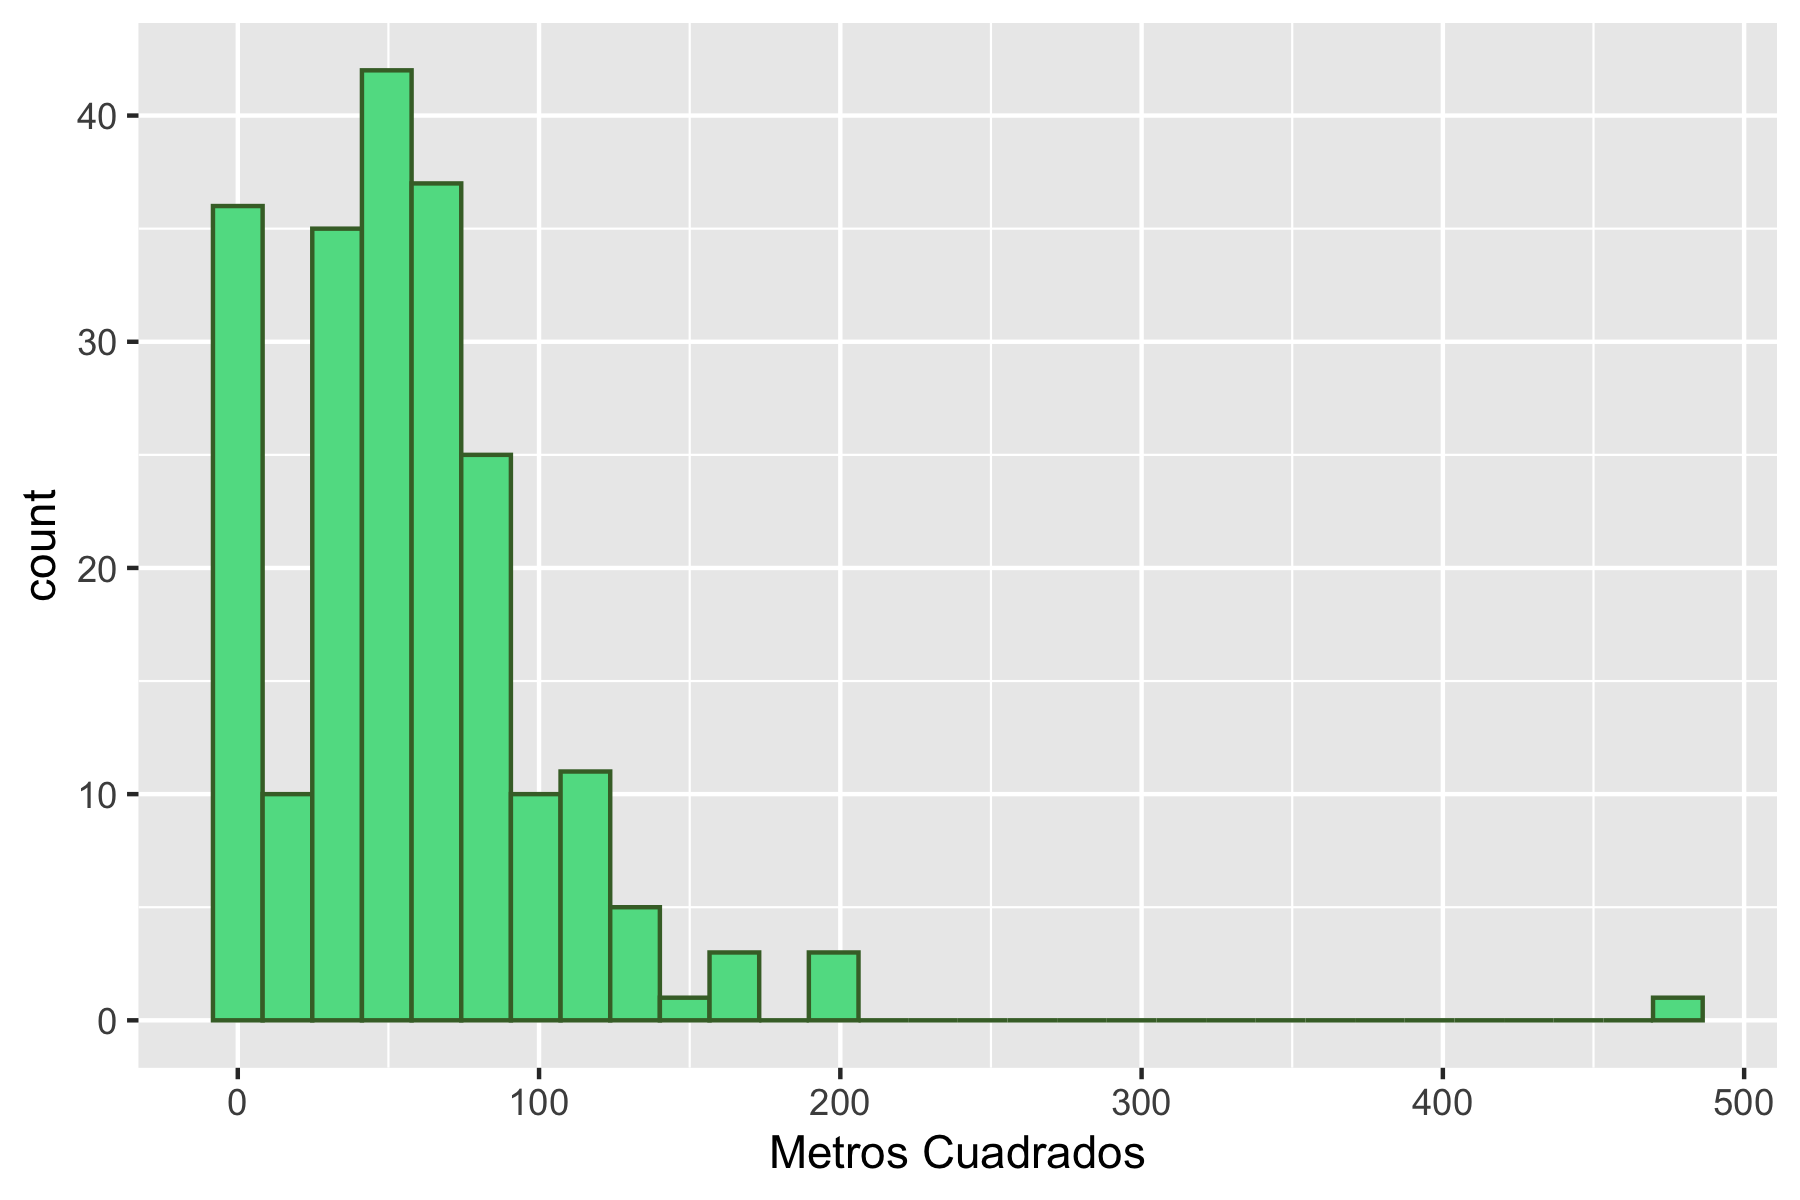

In [9]:
library(ggplot2)
ggplot(data=df_madrid, aes(x=Square.Meters))+
geom_histogram(bins=30, fill="#5ddd92", color="#446d32")+
xlab("Metros Cuadrados")

Asigna el valor NA a la columna Square.Meters de los apartamentos que tengan menos de 20 m^2

In [10]:
# He optado por asignar NA a los menores de 25m2 porque obtenía mejor cluster y predict
df_madrid$Square.Meters[!is.na(df_madrid$Square.Meters) & df_madrid$Square.Meters < 25] <- NA

Warning message:
“Removed 5428 rows containing non-finite values (stat_bin).”


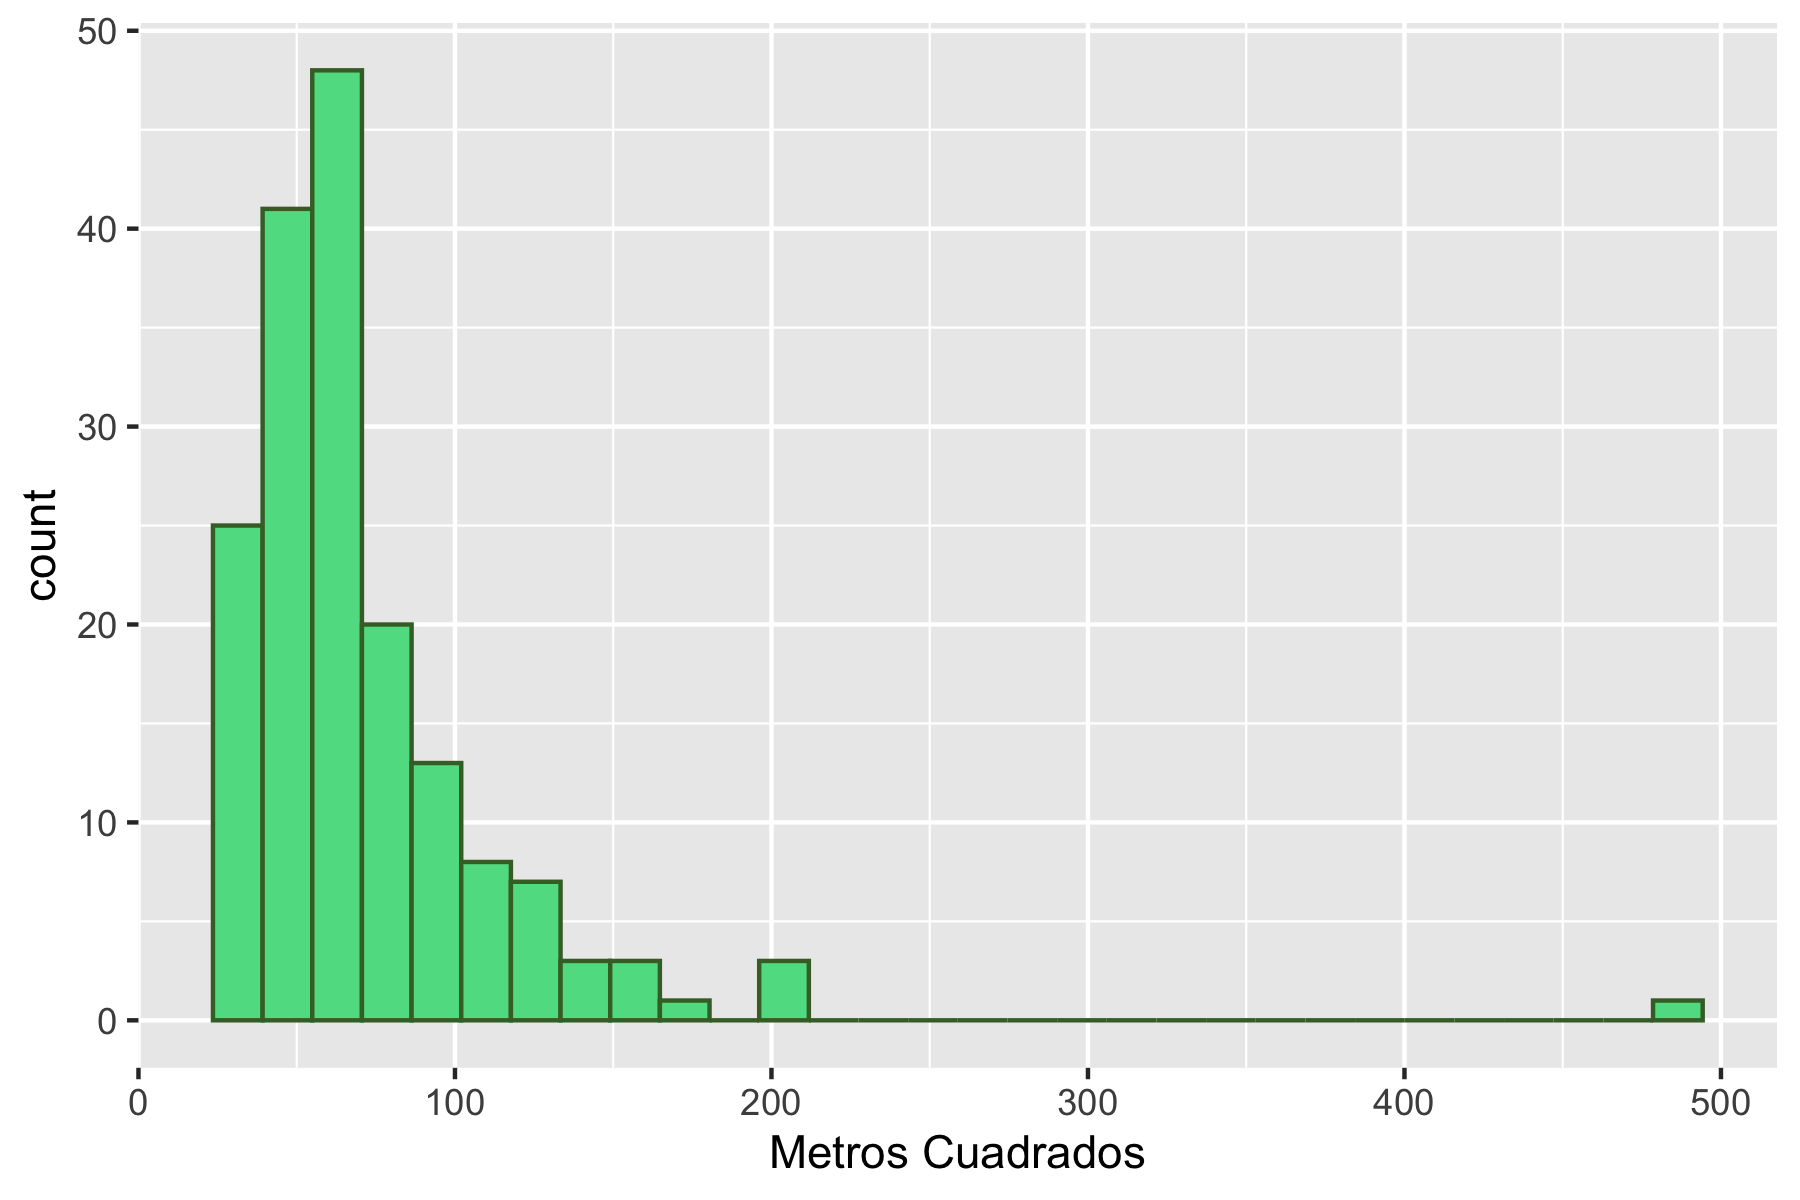

In [11]:
library(ggplot2)
ggplot(data=df_madrid, aes(x=Square.Meters))+
geom_histogram(bins=30, fill="#5ddd92", color="#446d32")+
xlab("Metros Cuadrados")

El barrio parece ser un indicador importante para los metros cuadrados de un apartamento.

Vamos a agrupar los barrios por metros cuadrados. Podemos usar una matriz de similaridad de Tukey tal y como hicimos en el curso de estadística:

Warning message in resm[lower.tri(resm)] <- round(tky.result$p.adj, 4):
“number of items to replace is not a multiple of replacement length”


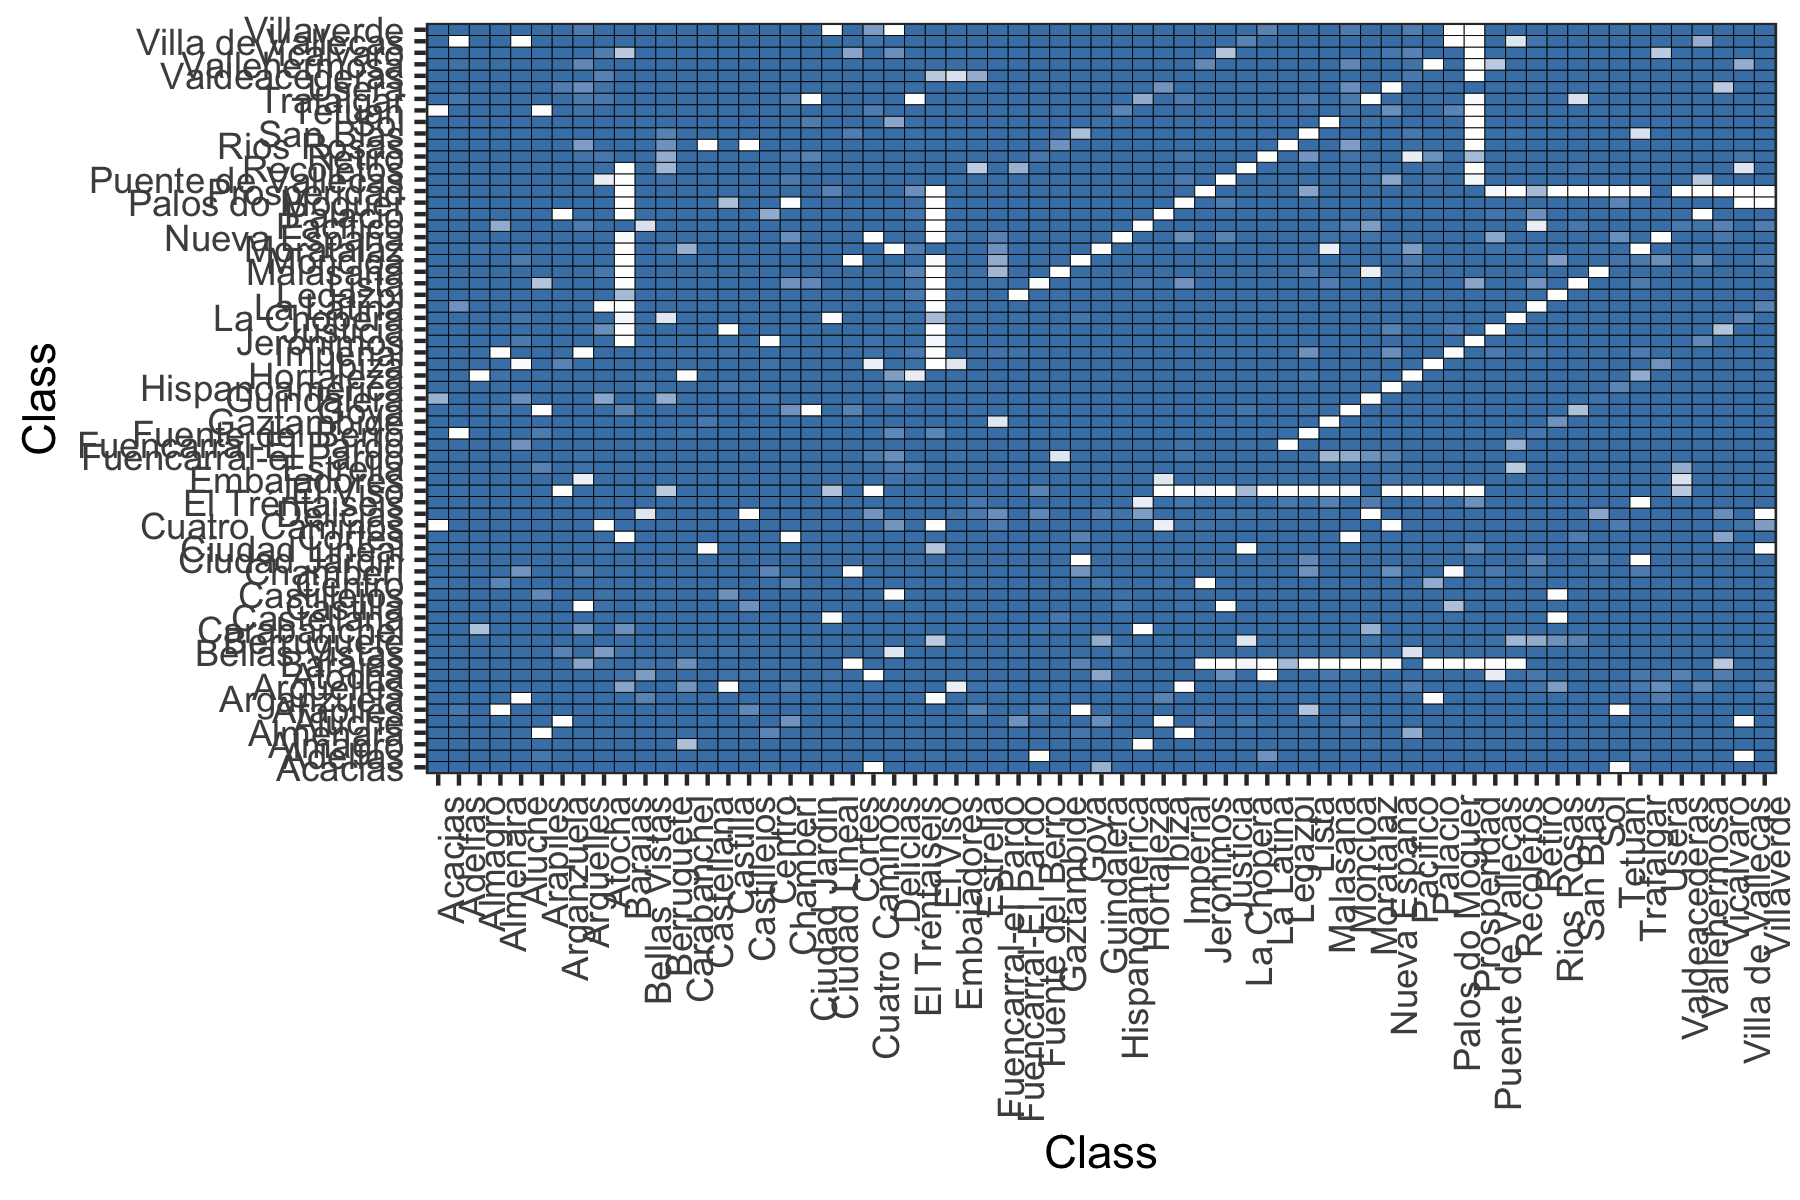

In [12]:
tky<-TukeyHSD(aov( formula=Square.Meters~Neighbourhood, data=df_madrid ))
tky.result<-data.frame(tky$Neighbourhood)
cn <-sort(unique(df_madrid$Neighbourhood))
resm <- matrix(NA, length(cn),length(cn))
rownames(resm) <- cn
colnames(resm) <- cn
resm[lower.tri(resm) ] <- round(tky.result$p.adj,4)
resm[upper.tri(resm) ] <- t(resm)[upper.tri(resm)] 
diag(resm) <- 1
library(ggplot2)
library(reshape2)
dfResm <- melt(resm)
ggplot(dfResm, aes(x=Var1, y=Var2, fill=value))+
  geom_tile(colour = "black")+
  scale_fill_gradient(low = "white",high = "steelblue")+
  ylab("Class")+xlab("Class")+theme_bw()+
  theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position="none")

Usando como variable de distancia: 1-resm
Dibuja un dendrograma de los diferentes barrios.


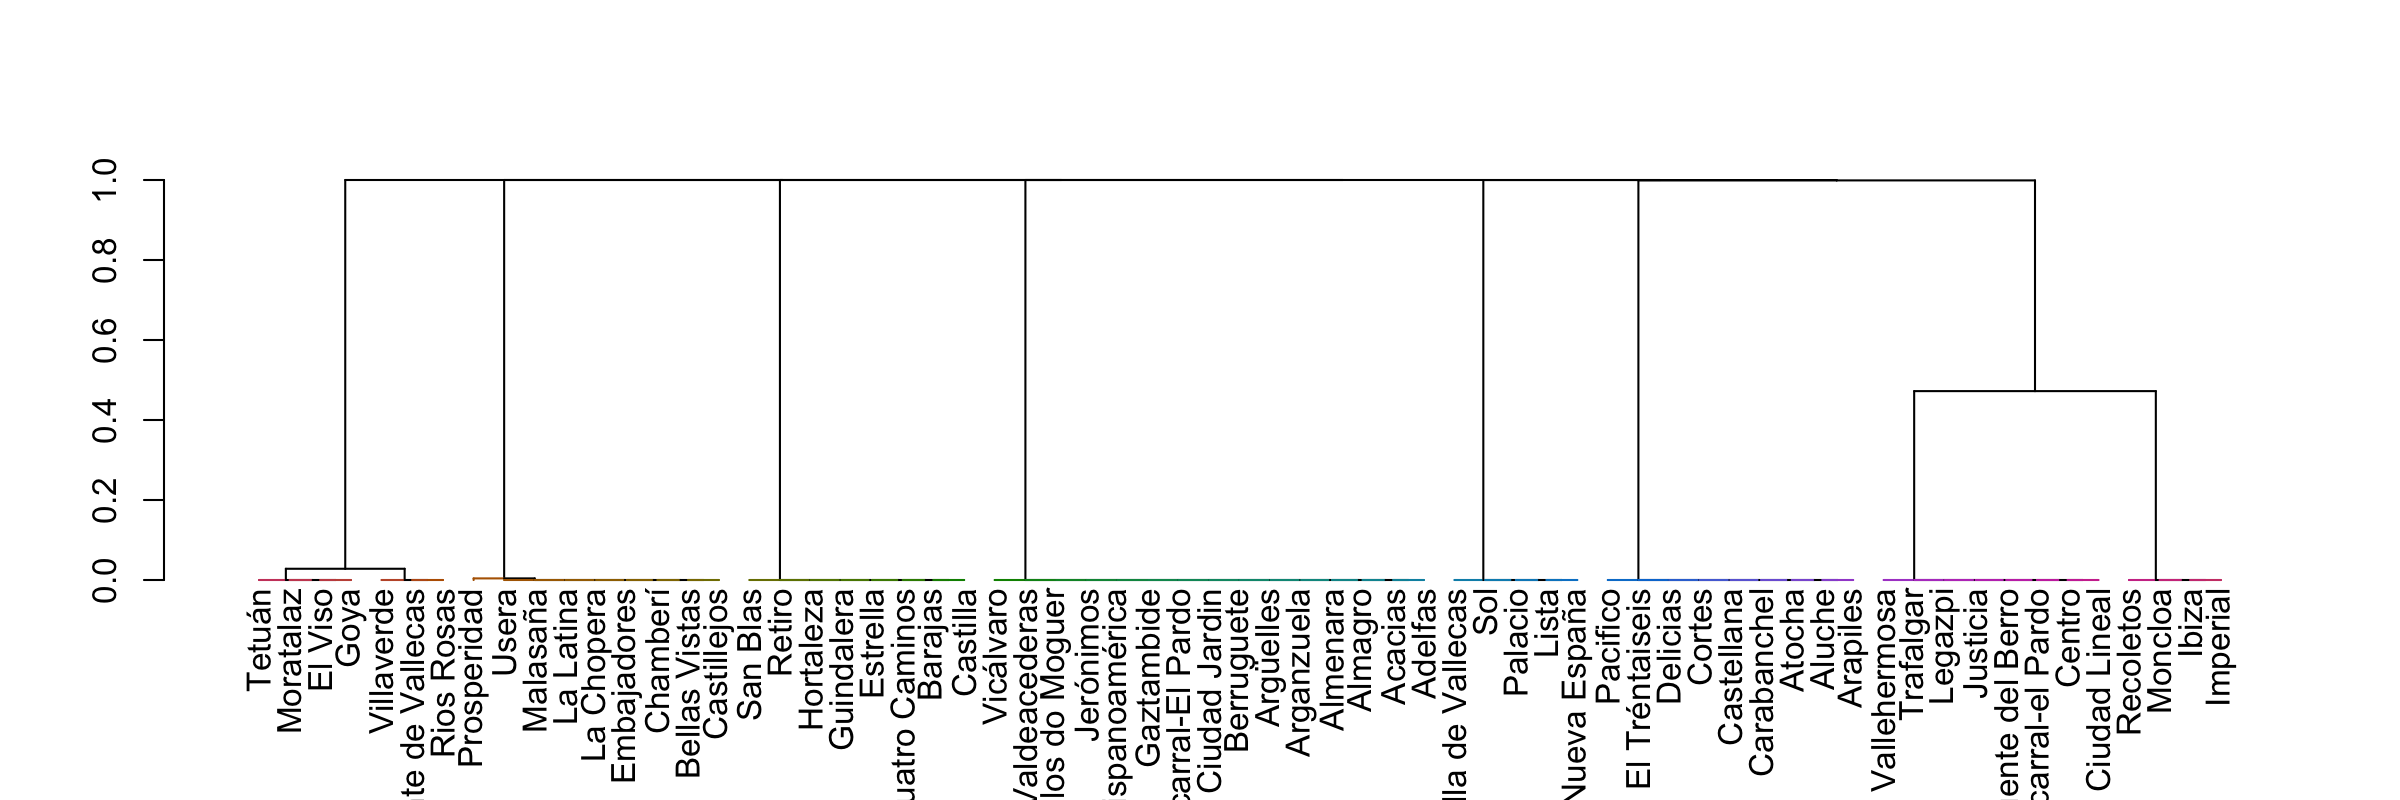

In [25]:
library(dendextend)
options(repr.plot.height=4,repr.plot.width=12)
d <- as.dist(1 - resm)
hc <- hclust(d,method="complete")
hcd <- as.dendrogram(hc)
plot(color_branches(hcd))

Estableciendo un punto de corte en 0.9, ¿cuantos clusters aparecen?

[1] "Número de clusters:  7"


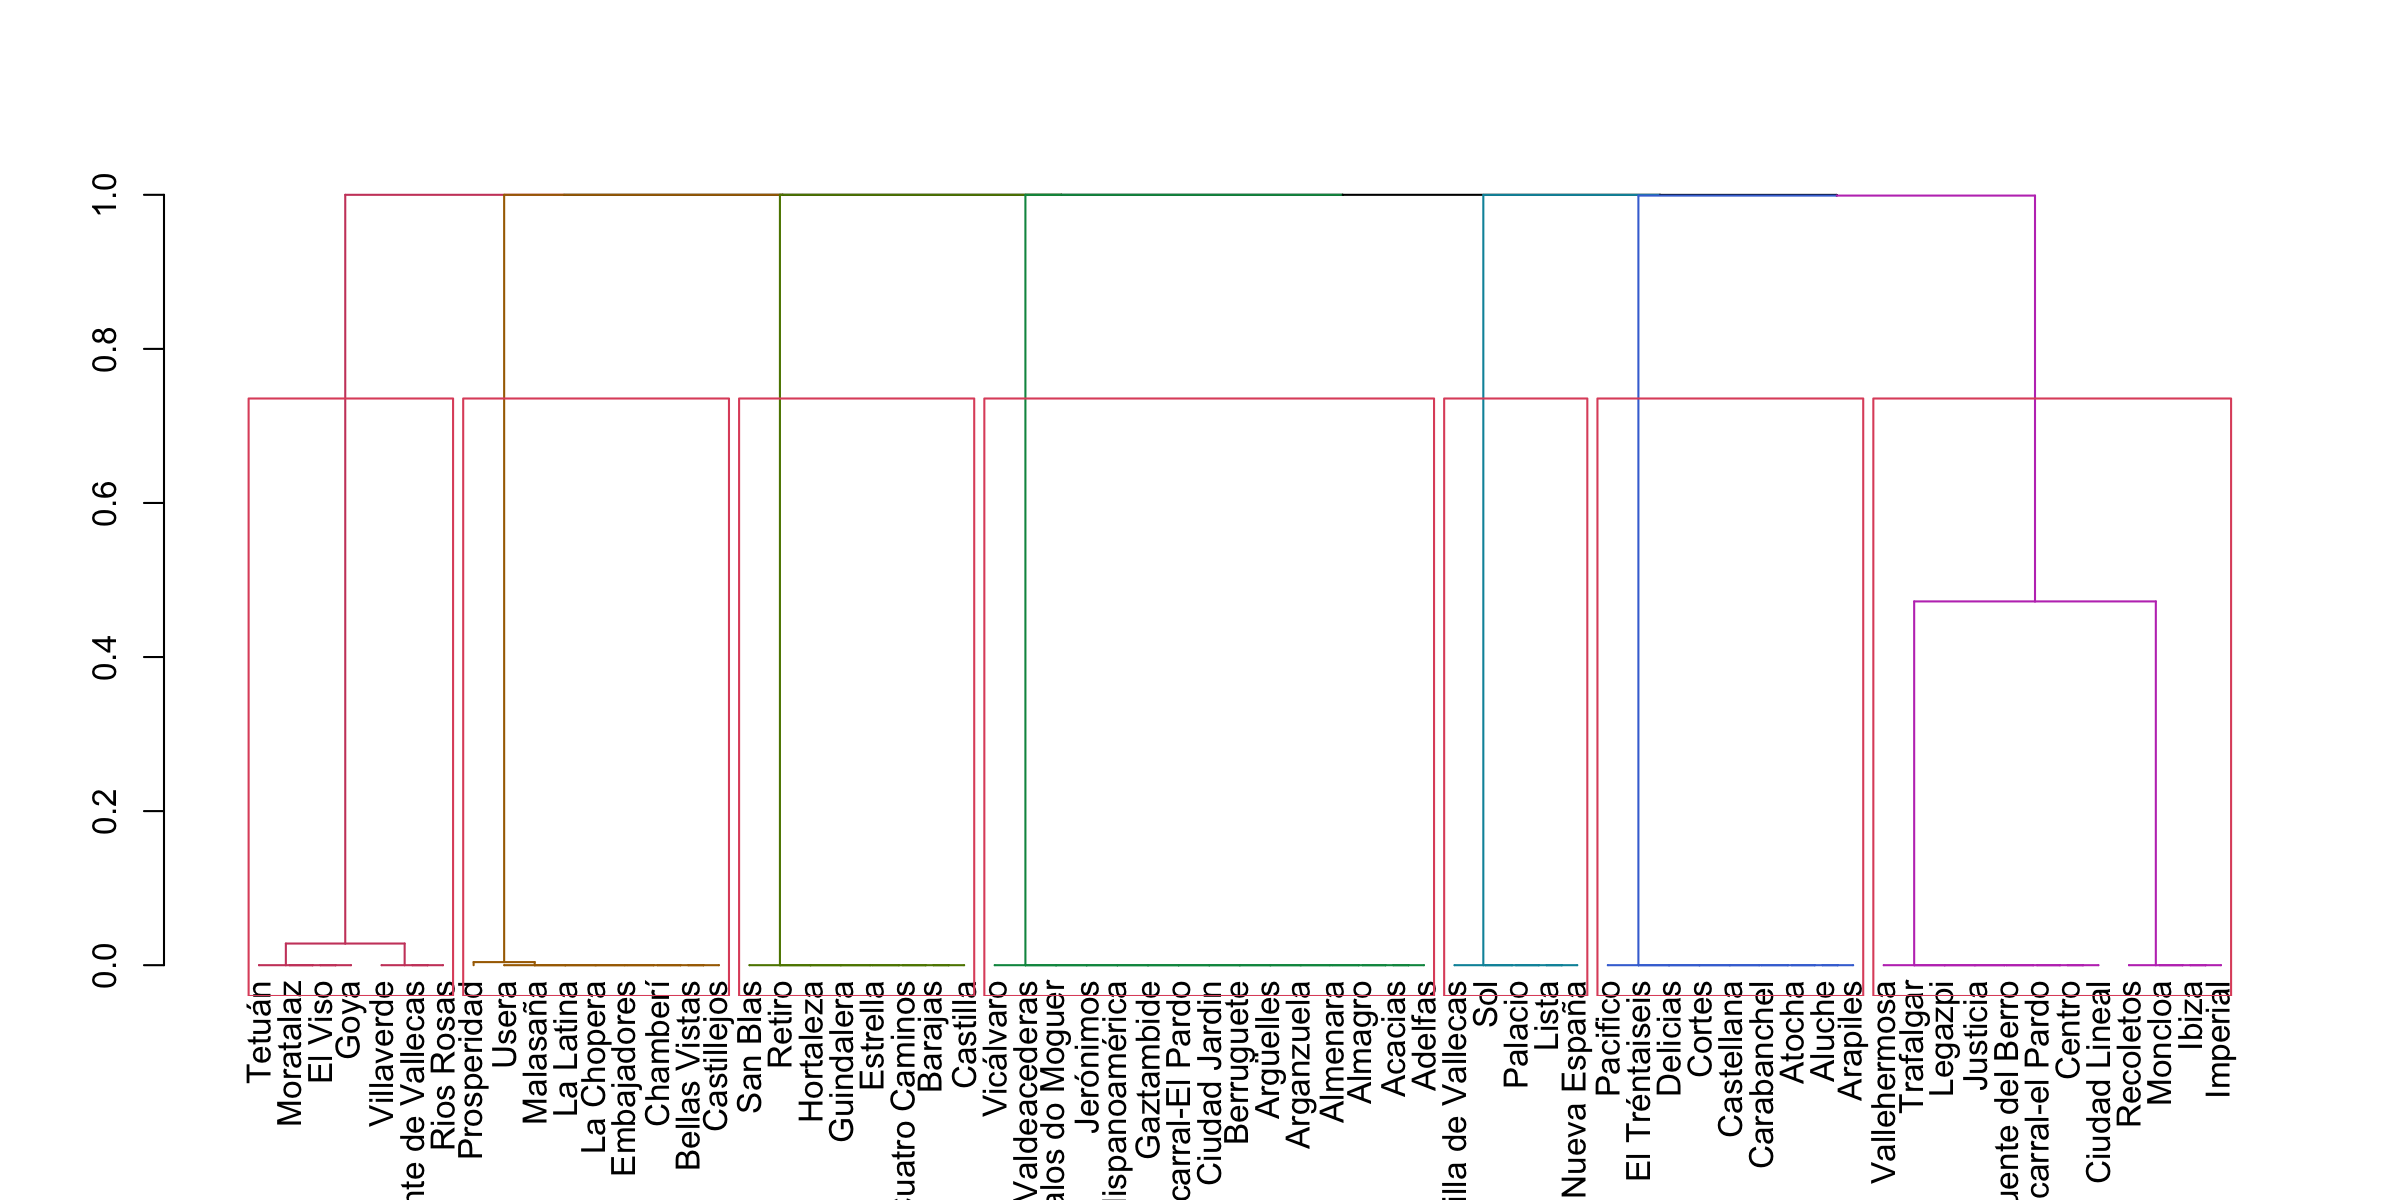

In [31]:
options(repr.plot.height=6,repr.plot.width=12)
plot(color_branches(hcd,h=0.9))
ncluster <- rect.hclust(hc, h=0.9)
print(paste("Número de clusters: ", length(ncluster)))

Vamos a crear una nueva columna en el dataframe df_madrid con un nuevo identificador marcado por los clusters obtenidos. Esta columna la llamaremos neighb_id

In [36]:
cluster <- as.factor(cutree(hc,h=0.9))
df_madrid$neighb_id <- cluster[df_madrid$Neighbourhood]
str(df_madrid)

'data.frame':	5601 obs. of  14 variables:
 $ Neighbourhood       : chr  "Palacio" "Palacio" "Palacio" "La Latina" ...
 $ Accommodates        : int  3 5 6 4 4 2 2 6 6 2 ...
 $ Bathrooms           : num  1 2 1 1 1 1 1 1 1 1 ...
 $ Bedrooms            : int  0 2 2 1 1 1 0 3 3 0 ...
 $ Beds                : int  2 3 4 2 1 1 1 3 6 1 ...
 $ Price               : int  65 100 89 49 89 61 72 85 170 60 ...
 $ Square.Feet         : int  NA NA NA 0 NA NA NA NA NA NA ...
 $ Guests.Included     : int  2 4 2 2 2 1 1 1 1 1 ...
 $ Extra.People        : int  10 25 10 20 15 0 0 0 0 0 ...
 $ Review.Scores.Rating: int  96 97 94 89 97 95 88 78 NA 89 ...
 $ Latitude            : num  40.4 40.4 40.4 40.4 40.4 ...
 $ Longitude           : num  -3.71 -3.71 -3.71 -3.71 -3.71 ...
 $ Square.Meters       : num  NA NA NA NA NA NA NA NA NA NA ...
 $ neighb_id           : Factor w/ 7 levels "1","2","3","4",..: 7 7 7 4 4 4 4 4 4 4 ...


Vamos a crear dos grupos, uno test y otro train.

Tratamos de predecir los metros cuadrados en función del resto de columnas del dataframe.

In [37]:
set.seed(1234)
idx <- sample(1:nrow(df_madrid),nrow(df_madrid)*0.7)
df_madrid_train <- df_madrid[idx,]
df_madrid_test <- df_madrid[-idx,]
paste("Número de muestras training:",nrow(df_madrid_train))
paste("Número de muestras testing:",nrow(df_madrid_test))

[1] "Número de muestras training: 3920"

[1] "Número de muestras testing: 1681"

In [38]:
# Probamos diferentes modelos
#Modelo_1
model_df_madrid<-lm(Square.Meters~Accommodates+Bedrooms+Bathrooms+Beds+Price+neighb_id,data=df_madrid_train)
summary(model_df_madrid)


Call:
lm(formula = Square.Meters ~ Accommodates + Bedrooms + Bathrooms + 
    Beds + Price + neighb_id, data = df_madrid_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-94.605 -12.382  -0.825  11.033 162.015 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   22.44238   11.58150   1.938  0.05524 .  
Accommodates  -1.47451    2.80210  -0.526  0.59981    
Bedrooms      14.20280    4.69312   3.026  0.00309 ** 
Bathrooms     26.35896    6.41396   4.110  7.7e-05 ***
Beds           7.10576    2.98687   2.379  0.01910 *  
Price          0.06562    0.04553   1.441  0.15237    
neighb_id2   -33.41060   12.56927  -2.658  0.00904 ** 
neighb_id3   -37.86962   13.38922  -2.828  0.00557 ** 
neighb_id4   -28.69136   10.10745  -2.839  0.00541 ** 
neighb_id5   -24.68185   12.19744  -2.024  0.04547 *  
neighb_id6   -20.09639   18.51403  -1.085  0.28011    
neighb_id7   -30.64117   10.62765  -2.883  0.00474 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’

In [39]:
# Modelo _2
model_df_madrid<-lm(Square.Meters~Bedrooms+Bathrooms+Beds+Price+neighb_id,data=df_madrid_train)
summary(model_df_madrid)


Call:
lm(formula = Square.Meters ~ Bedrooms + Bathrooms + Beds + Price + 
    neighb_id, data = df_madrid_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-95.540 -13.939  -0.474  10.206 162.420 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  20.19622   10.73076   1.882  0.06247 .  
Bedrooms     13.42414    4.43908   3.024  0.00310 ** 
Bathrooms    25.30059    6.07041   4.168 6.15e-05 ***
Beds          6.07244    2.24324   2.707  0.00787 ** 
Price         0.06799    0.04516   1.506  0.13499    
neighb_id2  -31.78348   12.14288  -2.617  0.01011 *  
neighb_id3  -37.36541   13.31092  -2.807  0.00591 ** 
neighb_id4  -27.91935    9.96749  -2.801  0.00602 ** 
neighb_id5  -23.83636   12.05134  -1.978  0.05044 .  
neighb_id6  -17.97346   18.00965  -0.998  0.32047    
neighb_id7  -30.13349   10.54892  -2.857  0.00512 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 29.4 on 110 degrees of freedom
  (37

In [40]:
# Modelo_3
model_df_madrid<-lm(Square.Meters~Bedrooms+Bathrooms+Beds+neighb_id,data=df_madrid_train)
summary(model_df_madrid)


Call:
lm(formula = Square.Meters ~ Bedrooms + Bathrooms + Beds + neighb_id, 
    data = df_madrid_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-99.508 -13.738   0.243  10.485 161.515 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   18.964     10.690   1.774 0.078773 .  
Bedrooms      14.820      4.377   3.386 0.000979 ***
Bathrooms     29.372      5.596   5.249 7.34e-07 ***
Beds           6.043      2.198   2.749 0.006970 ** 
neighb_id2   -26.505     11.727  -2.260 0.025742 *  
neighb_id3   -39.848     13.269  -3.003 0.003298 ** 
neighb_id4   -27.535     10.002  -2.753 0.006890 ** 
neighb_id5   -24.646     12.082  -2.040 0.043713 *  
neighb_id6   -20.297     18.030  -1.126 0.262700    
neighb_id7   -29.569     10.586  -2.793 0.006140 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 29.52 on 112 degrees of freedom
  (3798 observations deleted due to missingness)
Multiple R-squared:   0.71,	

In [41]:
# Modelo_4
model_df_madrid<-lm(Square.Meters~Bedrooms+Bathrooms+Beds,data=df_madrid_train)
summary(model_df_madrid)


Call:
lm(formula = Square.Meters ~ Bedrooms + Bathrooms + Beds, data = df_madrid_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-106.244  -12.194   -0.325   12.606  183.330 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -6.743      6.153  -1.096  0.27539    
Bedrooms      12.341      4.156   2.970  0.00361 ** 
Bathrooms     32.370      5.480   5.907 3.44e-08 ***
Beds           6.143      2.129   2.886  0.00464 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 30.19 on 118 degrees of freedom
  (3798 observations deleted due to missingness)
Multiple R-squared:  0.6805,	Adjusted R-squared:  0.6723 
F-statistic: 83.76 on 3 and 118 DF,  p-value: < 2.2e-16


In [72]:
# Finalmente nos quedamos con el modelo 3 que tiene el Adjusted R-squared más alto
model_df_madrid<-lm(Square.Meters~Bedrooms+Bathrooms+Beds+neighb_id,data=df_madrid_train)

In [73]:
df_madrid_test$predict_result<-predict(model_df_madrid, df_madrid_test)

Mirad el histograma de los residuos sobre el conjunto de test para evaluar la calidad de vuestro modelo

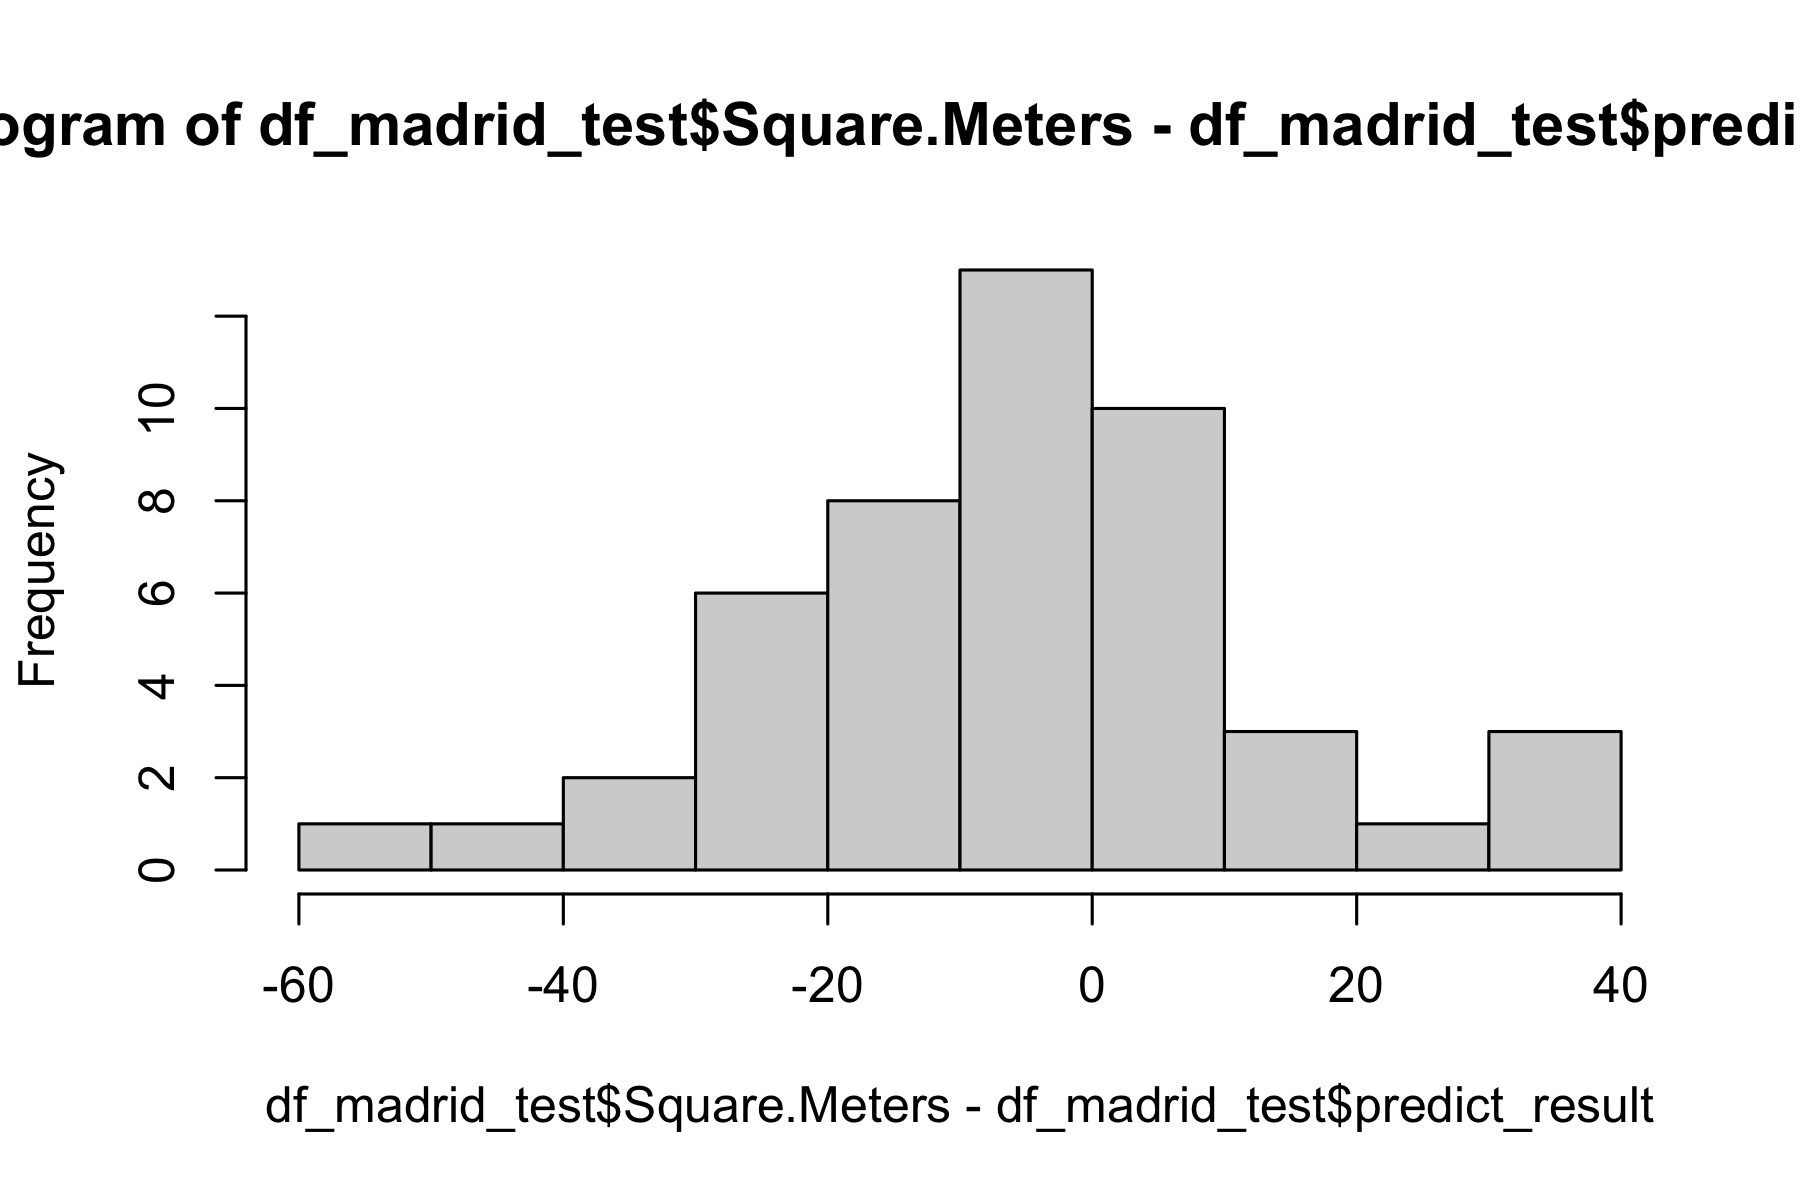

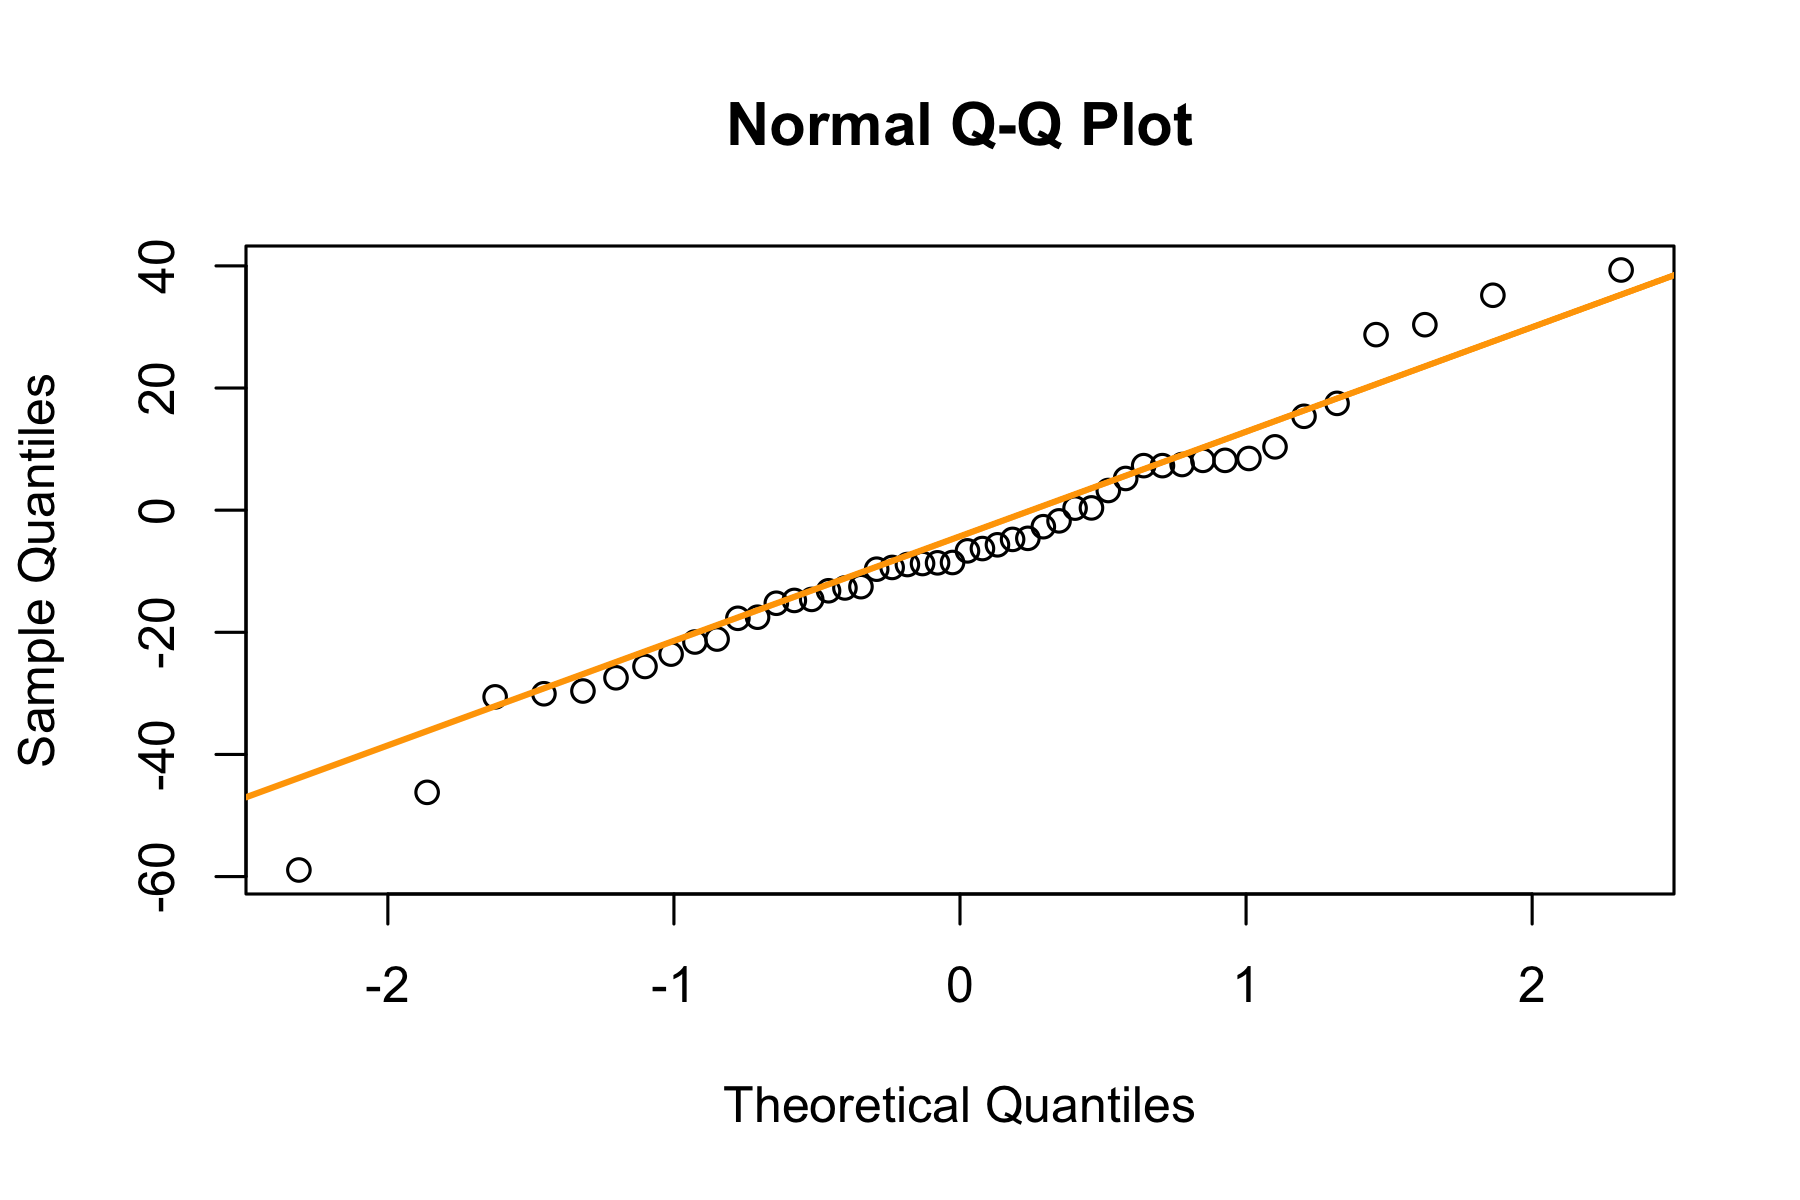

In [74]:
options(repr.plot.height=4,repr.plot.width=6,repr.plot.res = 300)
hist(df_madrid_test$Square.Meters-df_madrid_test$predict_result,10)
qqnorm(df_madrid_test$Square.Meters-df_madrid_test$predict_result)
qqline(df_madrid_test$Square.Meters-df_madrid_test$predict_result, col = 'orange', lwd =2)

In [75]:
mean_sqerror <- sqrt(mean((df_madrid_test$Square.Meters-df_madrid_test$predict_result)^2,na.rm = TRUE))
paste("El error cuadrático medio es:",round(mean_sqerror,2))

[1] "El error cuadrático medio es: 20.01"

Si tuvieramos un anuncio de un apartamento para 6 personas (Accommodates) con un precio de 80€/noche y 3 habitaciones en el barrio de Sol.
¿Cuantos metros cuadrados tendría?
¿Como varía sus metros cuadrados con cada habitación adicional?

In [115]:
df_apartment <- data.frame(
    "Accommodates" = 6,
    "Price" = 80,
    "Bedrooms" = 3,
    "Neighbourhood" = "Sol",
    "Bathrooms" = 1,
    "Beds" = 5,
    "neighb_id" = as.factor(7)
)

In [116]:
pr_meters_1 <- predict(model_df_madrid, df_apartment, na.action = na.pass)
paste("La predicción de metros es:", round(pr_meters_1,2))

[1] "La predicción de metros es: 93.44"

In [117]:
paste("Por cada habitación adicional los metros suben:",round(model_df_madrid$coefficients["Bedrooms"],2))

[1] "Por cada habitación adicional los metros suben: 14.82"

In [118]:
# Comprobamos que es así aplicando el modelo a un apartamento con una habitación más
df_apartment <- data.frame(
    "Accommodates" = 6,
    "Price" = 80,
    "Bedrooms" = 4,
    "Neighbourhood" = "Sol",
    "Bathrooms" = 1,
    "Beds" = 5,
    "neighb_id" = as.factor(7)
)
pr_meters_2 <- predict(model_df_madrid, df_apartment, na.action = na.pass)
paste("La diferencia entre la primera predicción y la segunda es:",round(pr_meters_2-pr_meters_1,2))

[1] "La diferencia entre la primera predicción y la segunda es: 14.82"

Rellenar los Square.Meters con valor NA con el estimado con el modelo anterior.

In [119]:
df_madrid$Predict.Meters <- predict(model_df_madrid, df_madrid)
index <- which(is.na(df_madrid$Square.Meters))
df_madrid$Square.Meters[index] <- df_madrid$Predict.Meters[index]
df_madrid$Square.Meters[df_madrid$Square.Meters<25] <- NA
head(df_madrid)

,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Square.Feet,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters,neighb_id,Predict.Meters
,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
18,Palacio,3,1,0,2,65,NA,2,10,96,40.41706,-3.709482,30.85419,7,30.85419
19,Palacio,5,2,2,3,100,NA,4,25,97,40.41934,-3.709556,95.90840,7,95.90840
20,Palacio,6,1,2,4,89,NA,2,10,94,40.42113,-3.708628,72.57997,7,72.57997
21,La Latina,4,1,1,2,49,0,2,20,89,40.41203,-3.709668,47.70765,4,47.70765
22,La Latina,4,1,1,1,89,NA,2,15,97,40.41205,-3.708516,41.66427,4,41.66427
25,La Latina,2,1,1,1,61,NA,1,0,95,40.41189,-3.712093,41.66427,4,41.66427


Usar PCA para encontrar el apartamento más cercano a uno dado.

Este algoritmo nos ayudaría a dado un apartamento que el algoritmo nos devolvería los 5 apartamentos más similares.


Crearemos una función tal que le pasemos un apartamento con los siguientes datos:
* Accommodates	
* Bathrooms	
* Bedrooms	
* Beds	
* Price	
* Guests.Included	
* Extra.People	
* Review.Scores.Rating	
* Latitude	
* Longitude	
* Square.Meters

y nos devuelva los 5 más similares de:

In [123]:
# Creamos un sub dataframe con las columnas numéricas y quitamos las filas con NA
df_sub_madrid <- subset(df_madrid, 
                 select = c('Accommodates','Bathrooms','Bedrooms','Beds','Price','Guests.Included',
                            'Extra.People','Review.Scores.Rating','Latitude', 'Longitude', 'Square.Meters'))
df_sub_madrid <- na.omit(df_sub_madrid)

# Creamos el apartamento del que queremos buscar los mas parecidos, cogiémdolo del propio dataframe
df_apartment <- df_sub_madrid[78,c('Accommodates','Bathrooms','Bedrooms','Beds','Price','Guests.Included',
                            'Extra.People','Review.Scores.Rating','Latitude', 'Longitude', 'Square.Meters')]
df_apartment

,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters
,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
208,4,1,2,2,114,2,15,95,40.41577,-3.702739,60.49321


In [124]:
# Función que devuelve los 5 apartamentos más parecidos
# Le pasamos el dataframe limpio de NA, el item que queremos comparar
most_similar_apts <- function(df_complete, new_item, num_items=5){
    pr_apt <- prcomp(df_complete,center = TRUE, scale. = TRUE)
    t_apt <- predict(pr_apt, newdata = new_item)
    dist<-rowSums((t_apt[rep(1, times = nrow(pr_apt$x)), ]-pr_apt$x)^2)
    df_complete[order(dist)[1:num_items],]
}

In [125]:
most_similar_apts(df_sub_madrid, df_apartment)

,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters
,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
208,4,1,2,2,114,2,15,95,40.41577,-3.702739,60.49321
1804,4,1,2,2,87,2,12,94,40.41854,-3.702551,60.49321
10328,4,1,2,2,87,2,15,96,40.41929,-3.706801,60.49321
783,4,1,2,2,90,2,15,97,40.41784,-3.710764,60.49321
3452,4,1,2,2,140,2,10,97,40.41433,-3.701612,63.55708


**Podemos observar como la primera aparición es el propio apartamento que estaba en el dataframe y luego las cuatro mas similares.**

Bonus: ¿de todas las coordenadas PCA cual es la que mejor permite clasificar por id de barrio?

¿Por qué?

In [126]:
pr_apt <- prcomp(df_sub_madrid,center = TRUE, scale. = TRUE)

In [127]:
pr_apt$x

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
18,-1.70934455,-0.73765980,-0.437449191,0.33649409,-0.366229000,0.149516500,0.402294402,-0.12894463,-0.88579743,0.2153456,-0.062237161
19,2.11948409,-0.95941298,-1.130468153,0.18487989,-0.603027555,-0.225964087,0.365620444,1.07344133,-0.03904804,0.0936765,-0.162747968
20,0.91303307,-0.46533377,0.132202840,-0.06017457,-0.150739655,0.931875992,-0.692263486,-0.66976280,-0.12895223,-0.1015310,-0.076923129
21,-0.90349809,-1.04661684,-0.616814894,-0.63128000,-0.089155053,-0.106159017,-0.377655950,0.11568120,-0.15223437,-0.1205151,-0.044892172
22,-1.00007227,-0.99177665,-0.569527017,0.44821383,-0.252682039,-0.225305792,0.248329286,-0.27999136,0.13989566,-0.5183532,0.006445976
25,-2.00318724,-0.54777170,0.764432669,0.69993654,-0.248093876,-0.042052707,0.099503461,0.14771734,0.32333227,0.1434666,-0.098159117
28,-2.55326878,-0.52726975,0.836795733,0.00405287,-0.294283777,-0.468330100,0.556003912,-0.12854889,-0.50299027,0.1577913,-0.045164989
29,0.76423139,-0.36646249,1.938839190,-1.28287003,0.226637953,0.355808329,-0.952308905,-0.48730960,0.96924723,-0.5088014,-0.084308858
35,-2.61960481,-0.40677669,0.722410060,0.07254937,-0.219465195,-0.334526209,0.462583736,0.01269400,-0.52620556,0.1344240,-0.049988645
39,-1.70749581,-0.03713571,0.455727133,1.32727516,-0.619390818,-0.142078364,0.400492733,-0.43245041,0.35392234,0.1484154,-0.113859826
